## UA Q2 basic characterization

includes RR, ESR, Rabi, T1

## Header that we always run

In [87]:
# set up non-QM hardware
import Labber
# connect to server 
client = Labber.connectToServer('localhost') # get list of instruments 
#instruments = client.getListOfInstrumentsString() 
#for instr in instruments: 
#    print(instr) # close connection 

# reset all QDevil channels to 0 V
QDevil = client.connectToInstrument('QDevil QDAC', dict(interface='Serial', address='3'))
for n in range(24):
    if n+1 < 10:
        QDevil.setValue("CH0" + str(n+1) + " Voltage", 0.0)
    else:
        QDevil.setValue("CH" + str(n+1) + " Voltage", 0.0)

DC_ss = 0
QDevil.setValue("CH02 Voltage", DC_ss)


# digital attenuators
Vaunix1 = client.connectToInstrument('Painter Vaunix Lab Brick Digital Attenuator', dict(interface='USB', address='25606'))
Vaunix2 = client.connectToInstrument('Painter Vaunix Lab Brick Digital Attenuator', dict(interface='USB', address='25607'))
ROI = 38
ROO = 10
Vaunix1.setValue("Attenuation", ROI)
Vaunix2.setValue("Attenuation", ROO)

# TWPA pump
SG = client.connectToInstrument('Rohde&Schwarz RF Source', dict(interface='TCPIP', address='192.168.88.2'))
freq_TWPA = 6326E6;
pwr_TWPA = -10;
SG.setValue('Frequency', freq_TWPA)
SG.setValue('Power', pwr_TWPA)

client.close()

In [9]:
from qm.qua import *
from qm.QuantumMachinesManager import QuantumMachinesManager
from qm import SimulationConfig, LoopbackInterface
from qm.octave import *
from qm.octave.octave_manager import ClockMode
from configuration import *
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from qm import SimulationConfig
from qualang_tools.bakery import baking
from qualang_tools.units import unit
import qdac as qdac
from scipy.io import savemat
from scipy.io import loadmat
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from qutip import *
import datetime 
import os
import time
import warnings
from qm import generate_qua_script

warnings.filterwarnings("ignore")

def wait_until_job_is_paused(current_job):
    """
    Waits until the OPX FPGA reaches the pause statement.
    Used when the OPX sequence needs to be synchronized with an external parameter sweep.

    :param current_job: the job object.
    """
    while not current_job.is_paused():
        time.sleep(0.01)
        pass
    return True

qubit_index = 0 # for UA Q1

now = datetime.datetime.now()
year = now.strftime("%Y")
month = now.strftime("%m")
day = now.strftime("%d")

tPath = os.path.join(r'Z:\LabberData_DF5\QM_Data_DF5',year,month,'Data_'+month+day)
if not os.path.exists(tPath):
   os.makedirs(tPath)

## Fitting functions

In [3]:
# fitting functions
def ESR_Shape( x, amp, sigma, x0, c ):
    return amp * sigma**2 / ( sigma**2 + ( x - x0 )**2) + c 

def ESR_Shape_double( x, amp, sigma, x0, c, amp2, sigma2, x02 ):
    return amp * sigma**2 / ( sigma**2 + ( x - x0 )**2) + c + amp2 * sigma2**2 / ( sigma2**2 + ( x - x02 )**2)

def Rabi_Shape( x, amp, f, phi, c):
    return amp * np.cos(2 * np.pi * f * x + phi) + c

def exp_decay( t, A, T1, c):
    return A*np.exp(-t/T1)+c

def Phi_flux_RR(flux, c, phi0):
    # Argument for the cosine flux tuning curve
    return 2*np.pi*c*flux + phi0

## Second order polynomial fit 
def poly2(x, a, b, c):
        return a * (x**2) + b * x + c

def ham(flux, out, wr, Ec, Ej, c, phi0, g):
    # Hamiltonian function
    # The flux is the independent variable
    # The following are fitting parameters: wr, Ec, Ej, c, phi0, g
    # The output is the resonator frequency for all the input flux values
    # The output frequency array is in units of MHz

    N = 4 # 0-3 photons

    a = tensor(destroy(N), qeye(N)) # cavity mode
    b = tensor(qeye(N), destroy(N)) # qubit

    f_ham = []

    # Hamiltonian as a function of flux
    for k in range(np.size(flux)):
        H = wr*a.dag()*a + (np.sqrt(8*Ec*Ej*np.abs(np.cos(Phi_flux_RR(flux[k],c, phi0))))-Ec)*b.dag()*b - Ec/2*b.dag()*b.dag()*b*b + g*(a*b.dag()+a.dag()*b)
        w, v = np.linalg.eig(H)
        
        for n_1 in range(v.shape[1]):
            v[:,n_1] = v[:,n_1]/np.inner(v[:,n_1],v[:,n_1])

            idx_00 = np.argmax(np.abs(v[0,:])) # |0,0>
            idx_01 = np.argmax(np.abs(v[N,:])) # |1,0> photon
            idx_02 = np.argmax(np.abs(v[1,:])) # |0,1> qubit
        if out == 1:
            f_ham.append(np.abs(np.maximum(w[idx_01],w[idx_02]) - w[idx_00]))
        elif out==2:
            f_ham.append(np.abs(np.minimum(w[idx_01],w[idx_02]) - w[idx_00]))
        else:
            pass
    f_ham = np.array(f_ham)
    return f_ham


def ESR_4th(arr_sz, num_steps, SS, *popt):
    # Computes ESR freqeuncies as a function of flux.
    # It creates a flux array based on two input parameters:
    # arr_sz: endpoint of array. Since it is symmetric, it is the same value
    # num_steps: number of flux points 
    # fits that to a Hamiltonian shifted by the SS so that it is centered at zero
    # and uses this to perform a fit to a fourth order polynomial with only even terms.
    # The function finally outputs the ESR frequencies as a function of flux
    x_fit_r = np.array([np.linspace(-arr_sz, arr_sz, num_steps)])
    y_fit_r = ham(x_fit_r - np.abs(SS), 2, *popt)
    Q_fit_p4_r = np.polyfit(x_fit_r, y_fit_r, 4)
    return Q_fit_p4_r[0]* x_fit_r**4 + Q_fit_p4_r[2] * x_fit_r**2 + Q_fit_p4_r[4]


## RR spectroscopy

In [122]:
%matplotlib qt
print("Start running ...")

now = datetime.datetime.now()
month = now.strftime("%m")
day = now.strftime("%d")
hour = now.strftime("%H")
minute = now.strftime("%M")

exp_name = 'RR_spec'
qubit_name = 'UA_Q2'

f_str = qubit_name + '_' + exp_name + '_' + month + day + '-' + hour + minute
file_name= f_str + '.mat'
json_name = f_str + '_state.json'

# Set-up the machine and get the config #
machine = QuAM("quam_state.json")
config = build_config(machine)

qubit_index = 1
res_if = machine.resonators[qubit_index].f_readout - machine.resonators[qubit_index].lo
n_avg = 5_000
cooldown_time = 20_000 # convert to ns in the wait function!

# The QUA program #
RR_freq_sweep = np.arange(-20e6, 20e6, 0.1e6)
RR_freq_sweep = RR_freq_sweep.astype(int)

with program() as resonator_spec:
    n = declare(int)
    n_st = declare_stream()
    df = declare(int)
    I = declare(fixed)
    Q = declare(fixed)
    I_st = declare_stream()
    Q_st = declare_stream()

    with for_(n, 0, n < n_avg, n + 1):
        save(n, n_st)
        with for_(*from_array(df, RR_freq_sweep)):
            update_frequency(machine.resonators[qubit_index].name, df + res_if)
            #play("pi" * amp(1.0), machine.qubits[qubit_index].name)
            #align(machine.qubits[qubit_index].name, machine.resonators[qubit_index].name)
            measure(
                "readout"*amp(1),
                machine.resonators[qubit_index].name,
                None,
                dual_demod.full("cos", "out1", "sin", "out2", I),
                dual_demod.full("minus_sin", "out1", "cos", "out2", Q),
            )
            wait(cooldown_time * u.ns, machine.resonators[qubit_index].name)
            save(I, I_st)
            save(Q, Q_st)

    with stream_processing():
        n_st.save('iteration')
        I_st.buffer(len(RR_freq_sweep)).average().save("I")
        Q_st.buffer(len(RR_freq_sweep)).average().save("Q")

#  Open Communication with the QOP  #
# qmm = QuantumMachinesManager(machine.network.qop_ip, cluster_name=machine.network.cluster_name, octave=octave_config)
# qmm = QuantumMachinesManager(machine.network.qop_ip, port = '9510', octave=octave_config, log_level = "ERROR")
qmm = QuantumMachinesManager(machine.network.qop_ip, port = '9510', octave=octave_config)

# Simulate or execute #
simulate = False # simulation is useful to see the sequence, especially the timing (clock cycle vs ns)

if simulate:
    simulation_config = SimulationConfig(duration=1000)
    job = qmm.simulate(config, resonator_spec, simulation_config)
    job.get_simulated_samples().con1.plot()
else:
    qm = qmm.open_qm(config)
    job = qm.execute(resonator_spec)
    # Get results from QUA program
    results = fetching_tool(job, data_list=["I", "Q", "iteration"], mode="live")
    # Live plotting
    %matplotlib qt
    fig = plt.figure()
    plt.rcParams['figure.figsize'] = [12, 8]
    interrupt_on_close(fig, job)  # Interrupts the job when closing the figure
    while results.is_processing():
        # Fetch results
        I, Q, iteration = results.fetch_all()
        I = u.demod2volts(I, machine.resonators[qubit_index].readout_pulse_length)
        Q = u.demod2volts(Q, machine.resonators[qubit_index].readout_pulse_length)
        # progress bar
        progress_counter(iteration, n_avg, start_time=results.get_start_time())
        plt.cla()
        plt.title("Resonator spectroscopy")
        plt.plot((machine.resonators[qubit_index].f_readout + RR_freq_sweep ) / u.MHz, np.sqrt(I**2 +  Q**2), ".")
        plt.xlabel("Frequency [MHz]")
        plt.ylabel(r"$\sqrt{I^2 + Q^2}$ [V]")


Start running ...
2023-10-04 13:12:20,519 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2023-10-04 13:12:20,526 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


2023-10-04 13:12:21,871 - qm - INFO     - Sending program to QOP for compilation


INFO:qm.api.frontend_api:Sending program to QOP for compilation


2023-10-04 13:12:22,138 - qm - INFO     - Executing program


INFO:qm.QuantumMachine:Executing program


Progress: [##################################################] 100.0% (n=5000/5000) --> elapsed time: 41.32s
Progress: [##################################################] 100.0% (n=5000/5000) --> elapsed time: 41.41s
Execution stopped by user!


In [121]:
# Fetch results
%matplotlib qt
I, Q, iteration = results.fetch_all()
# Convert I & Q to Volts
I = u.demod2volts(I, machine.resonators[qubit_index].readout_pulse_length)
Q = u.demod2volts(Q, machine.resonators[qubit_index].readout_pulse_length)
sig_amp = np.sqrt(I**2 + Q**2)
# detrend removes the linear increase of phase
sig_phase = signal.detrend(np.unwrap(np.angle(I + 1j * Q)))
idx = np.argmin(sig_amp) # find minimum
print(f"IF offset to add to IF: {RR_freq_sweep[idx] / u.MHz:.6f} MHz")

plt.close('all')
%matplotlib inline
# 1D spectroscopy plot
fig = plt.figure(figsize=[8, 4])
plt.title("Resonator spectroscopy")
plt.plot((machine.resonators[qubit_index].f_readout + RR_freq_sweep ) / u.MHz, sig_amp, ".")
plt.xlabel("Frequency [MHz]")
plt.ylabel(r"$\sqrt{I^2 + Q^2}$ [V]")
plt.axvline(x = (machine.resonators[qubit_index].f_readout + RR_freq_sweep[idx]) / u.MHz)

ValueError: too many values to unpack (expected 3)

In [19]:
savemat(os.path.join(tPath, file_name), {"RR_freq": machine.resonators[qubit_index].f_readout + RR_freq_sweep, "sig_amp": sig_amp, "sig_phase": sig_phase, "DC_CH07": 0, "ROI": ROI, "ROO": ROO, "freq_TWPA": freq_TWPA, "pwr_TWPA": pwr_TWPA})
machine._save(os.path.join(tPath, json_name), flat_data=False)

In [101]:
# Modify machine and save
machine.resonators[qubit_index].f_readout += 1.8E6
# machine.resonators[qubit_index].readout_pulse_amp=0.3*0.8
# machine.resonators[qubit_index].lo = machine.resonators[qubit_index].f_readout + 50E6
machine._save("quam_state.json", flat_data=False)

In [ ]:
# This can be used to load specific data files to plot the resonator when qubit is at |e> and |g>
file_name = 'UA_Q2_RR_spec_0830-1038'
data = loadmat(os.path.join(tPath, file_name))
freq = data['RR_freq'][0]
sig = data['sig']

file_name_g = 'UA_Q2_RR_spec_0830-1036'
data = loadmat(os.path.join(tPath, file_name_g))
freq_g = data['RR_freq'][0]
sig_g = data['sig']

fig = plt.figure(figsize=[8, 4])
plt.title("Resonator spectroscopy")
plt.plot(freq , sig.T, ".")
plt.plot(freq_g , sig_g.T, ".")         
plt.xlabel("Frequency [MHz]")
plt.ylabel(r"$\sqrt{I^2 + Q^2}$ [V]")
plt.legend(["e", "g"])

## Flux sweep

In [106]:
print("Start running ...")

now = datetime.datetime.now()
month = now.strftime("%m")
day = now.strftime("%d")
hour = now.strftime("%H")
minute = now.strftime("%M")

exp_name = 'RR_spec_flux_sweep'
qubit_name = 'UA_Q2'

f_str = qubit_name + '_' + exp_name + '_' + month + day + '-' + hour + minute
file_name= f_str+'.mat'
json_name = f_str + '_state.json'


# Set-up the machine and get the config #
machine = QuAM("quam_state.json")
config = build_config(machine)

# Program-specific variables #
n_avg = 5000  # Number of averaging loops

cooldown_time = 20_000  # Resonator cooldown time, convert to ns in the wait() function 
flux_settle_time = 250  # Flux settle time for fast flux

dc_flux_sweep = np.arange(-5,5 + 0.1,0.2)
RR_freq_sweep = np.arange(-7.5e6, 5e6, 0.5e6)


res_if = machine.resonators[qubit_index].f_readout - machine.resonators[qubit_index].lo

client = Labber.connectToServer('localhost') # get list of instruments 
QDevil = client.connectToInstrument('QDevil QDAC', dict(interface='Serial', address='3'))
qubit_index = 1
start_time = time.time()

with program() as resonator_spec_2D:
    n = declare(int)  # Averaging index
    i = declare(int)  # DC sweep index
    df = declare(int)  # Resonator frequency
    I = declare(fixed)
    Q = declare(fixed)
    I_st = declare_stream()
    Q_st = declare_stream()
    n_st = declare_stream()

    with for_(i, 0, i < len(dc_flux_sweep) + 1, i + 1):
        # The QUA program #
        pause()
        with for_(n, 0, n < n_avg, n + 1):
            with for_(*from_array(df, RR_freq_sweep)):
                # Update the resonator frequency
                update_frequency(machine.resonators[qubit_index].name, df + res_if)
                # Measure the resonator
                measure(
                    "readout",
                    machine.resonators[qubit_index].name,
                    None,
                    dual_demod.full("cos", "out1", "sin", "out2", I),
                    dual_demod.full("minus_sin", "out1", "cos", "out2", Q),
                )
                # Wait for the resonator to cooldown
                wait(cooldown_time * u.ns, machine.resonators[qubit_index].name)
                # Save data to the stream processing
                save(I, I_st)
                save(Q, Q_st)
        save(i, n_st)

    with stream_processing():
        I_st.buffer(len(RR_freq_sweep)).buffer(n_avg).map(FUNCTIONS.average()).save_all("I")
        Q_st.buffer(len(RR_freq_sweep)).buffer(n_avg).map(FUNCTIONS.average()).save_all("Q")
        n_st.save_all("iteration")

###############
# Run Program #
###############
#  Open Communication with the QOP  #
# qmm = QuantumMachinesManager(machine.network.qop_ip, cluster_name=machine.network.cluster_name, octave=octave_config)
# qmm = QuantumMachinesManager(machine.network.qop_ip, port = '9510', octave=octave_config, log_level = "ERROR")
qmm = QuantumMachinesManager(machine.network.qop_ip, port = '9510', octave=octave_config)

qm = qmm.open_qm(config)
job = qm.execute(resonator_spec_2D)
# Creates results handles to fetch the data
res_handles = job.result_handles
I_handle = res_handles.get("I")
Q_handle = res_handles.get("Q")
n_handle = res_handles.get("iteration")

# Initialize empty vectors to store the global 'I' & 'Q' results
I_tot = []
Q_tot = []
# Live plotting
fig = plt.figure()
plt.rcParams['figure.figsize'] = [8, 4]
interrupt_on_close(fig, job)  # Interrupts the job when closing the figure

for i in range(len(dc_flux_sweep)):
    # set QDAC voltage
    dc_flux = dc_flux_sweep[i]
    QDevil.setValue("CH02 Voltage", dc_flux)
    # Resume the QUA program
    job.resume()
    # Wait until the program reaches the 'pause' statement again, indicating that the QUA program is done
    wait_until_job_is_paused(job)
    
    # Wait until the data of this run is processed by the stream processing
    I_handle.wait_for_values(i + 1)
    Q_handle.wait_for_values(i + 1)
    n_handle.wait_for_values(i + 1)
    
    # Fetch the data from the last OPX run corresponding to the current LO frequency
    I = np.concatenate(I_handle.fetch(i)["value"])
    Q = np.concatenate(Q_handle.fetch(i)["value"])
    iteration = n_handle.fetch(i)["value"][0]
    # Update the list of global results
    I_tot.append(I)
    Q_tot.append(Q)
    # Progress bar
    progress_counter(iteration, len(dc_flux_sweep))
    
    # Convert results into Volts
    sigs = u.demod2volts(I + 1j * Q, machine.resonators[qubit_index].readout_pulse_length)
    sig_amp = np.abs(sigs)  # Amplitude
    sig_phase = np.angle(sigs)  # Phase
    # Plot results
    plt.suptitle("RR spectroscopy")
    plt.title("Resonator spectroscopy")
    plt.plot((machine.resonators[qubit_index].f_readout + RR_freq_sweep ) / u.MHz, sig_amp, ".")
    plt.xlabel("Frequency [MHz]")
    plt.ylabel(r"$\sqrt{I^2 + Q^2}$ [V]")

# Interrupt the FPGA program
job.halt()

Start running ...
2023-10-04 12:05:06,663 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2023-10-04 12:05:06,672 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


2023-10-04 12:05:07,791 - qm - INFO     - Sending program to QOP for compilation


INFO:qm.api.frontend_api:Sending program to QOP for compilation


2023-10-04 12:05:08,035 - qm - INFO     - Executing program


INFO:qm.QuantumMachine:Executing program


Progress: [##################################################] 100.0% (n=51/51)


True

Execution stopped by user!


In [43]:
client.close()

### Process the data from experimental run

In [107]:
%matplotlib qt
I = np.concatenate(I_tot)
Q = np.concatenate(Q_tot)
sigs = u.demod2volts(I + 1j * Q, machine.resonators[qubit_index].readout_pulse_length)
sig_amp = np.abs(sigs)  # Amplitude
sig_phase = np.angle(sigs)  # Phase

# Final plot

sig = np.reshape(sig_amp, (np.size(dc_flux_sweep), np.size(machine.resonators[qubit_index].f_readout + RR_freq_sweep)))
phase = np.reshape(sig_phase, (np.size(dc_flux_sweep), np.size(machine.resonators[qubit_index].f_readout + RR_freq_sweep)))
fig = plt.figure()
plt.rcParams['figure.figsize'] = [8, 4]
plt.cla()

# 2D spectroscopy plot
plt.title("Resonator spectroscopy tuning curve")
plt.pcolormesh( np.linspace(np.min(dc_flux_sweep), np.max(dc_flux_sweep), np.size(dc_flux_sweep)),
               np.linspace(np.min(machine.resonators[qubit_index].f_readout + RR_freq_sweep), 
                           np.max(machine.resonators[qubit_index].f_readout + RR_freq_sweep), 
                           np.size(machine.resonators[qubit_index].f_readout + RR_freq_sweep))/1e6, 
               sig.T, shading="nearest", cmap="seismic")
plt.xlabel("DC flux level [V]")
plt.ylabel("Frequency [MHz]")
plt.colorbar()


In [108]:
%matplotlib qt
I = np.concatenate(I_tot)
Q = np.concatenate(Q_tot)
sigs = u.demod2volts(I + 1j * Q, machine.resonators[qubit_index].readout_pulse_length)
sig_amp = np.abs(sigs)  # Amplitude
sig_phase = np.angle(sigs)  # Phase

# Final plot

sig = np.reshape(sig_amp, (np.size(dc_flux_sweep), np.size(machine.resonators[qubit_index].f_readout + RR_freq_sweep)))
phase = np.reshape(sig_phase, (np.size(dc_flux_sweep), np.size(machine.resonators[qubit_index].f_readout + RR_freq_sweep)))
fig = plt.figure()
plt.rcParams['figure.figsize'] = [8, 4]
plt.cla()

# 2D spectroscopy plot
plt.title("Resonator spectroscopy tuning curve")
plt.pcolormesh( np.linspace(np.min(dc_flux_sweep), np.max(dc_flux_sweep), np.size(dc_flux_sweep)),
               np.linspace(np.min(machine.resonators[qubit_index].f_readout + RR_freq_sweep), 
                           np.max(machine.resonators[qubit_index].f_readout + RR_freq_sweep), 
                           np.size(machine.resonators[qubit_index].f_readout + RR_freq_sweep))/1e6, 
               sig.T, shading="nearest", cmap="seismic")
plt.xlabel("DC flux level [V]")
plt.ylabel("Frequency [MHz]")
plt.colorbar()

# Initial guess
wr = machine.resonators[qubit_index].f_readout/1e6 # Resonator frequency
Ec = 170.080 # Capacitive energy
Ej = 30642.9 # Inductive energy 
c = 0.05 # Period in cosine function for flux
phi0 = 0.4 # Offset in cosine function for flux
g = 74.965 # RR-qubit coupling

# Array of initial guess
guess = [wr, Ec, Ej, c, phi0, g]

# Frequency output from hamiltonian function using initial guess
freq_fit_guess = ham(dc_flux_sweep, 1, *guess)

# Plot of initial guess
# plt.plot(flux.T, freq_fit_guess)

freq = machine.resonators[qubit_index].f_readout + RR_freq_sweep
# Determine minima of signal to use as ydata for fitting
minimas = []
for i in range(np.size(dc_flux_sweep)):
    minimas.append(freq[np.argmin(sig[i])])
minimas = np.array(minimas)


## Plot minima of signal
plt.scatter(dc_flux_sweep.T, minimas/1e6)

minimas_mhz = minimas/1e6

# Fit data from minima of signal to Hamiltonian function
# Initial guess is given by p0
# Bounds are necessary. The order is bounds = ((min_wr, min_Ec, min_Ej, min_c, min_phi0, min_g), (max_wr, max_Ec, max_Ej, max_c, max_phi0, max_g))
popt, _ = curve_fit(lambda dc_flux_sweep, *guess: ham(dc_flux_sweep, 1, *guess), 
                    xdata = dc_flux_sweep, ydata = minimas_mhz, p0=guess, check_finite = "true", bounds = ((wr-200, Ec-100, Ej-20000, 0.0001, -4, g-50),(wr+200, Ec+100 ,Ej+ 20000, 4, 4, g+50)))

# This is the frequency output from the fitted data
freq_fit = ham(dc_flux_sweep, 1, *popt)

# Plot the fitted data
plt.plot(dc_flux_sweep.T, freq_fit)
# plt.legend(["guess", "fit"])
plt.legend(["fit"])



In [35]:
savemat(os.path.join(tPath, file_name), {"RR_freq": freq, "sig_amp": sig_amp, "sig_phase": sig_phase, "dc_flux_sweep": dc_flux_sweep, "ROI": ROI, "ROO": ROO, "freq_TWPA": freq_TWPA, "pwr_TWPA": pwr_TWPA})
machine._save(os.path.join(tPath, json_name), flat_data=False)

In [109]:
# Fitted ESR plot
freq_fit_qubit = ham(dc_flux_sweep, 2, *popt)

plt.title("Qubit spectroscopy tuning curve")
plt.plot(dc_flux_sweep.T, freq_fit_qubit)
plt.xlabel("DC flux level [V]")
plt.ylabel("Frequency [MHz]")

# SS from fitting to Hamiltonian parameters
SS = (-popt[4])/(2*np.pi*popt[3])
# Get the sweet spot based from fitted parameters to Hamiltonian
# Only cosine term matters for this
print('SS at: %.6f\n' % SS) 

# Fit ESR to a fourth order polynomial centered at zero (SS was shifted)
num_steps = 199
arr_sz = 0.99 # Choose half of the size we will sweep around SS
# Shift SS to be at 0 V, as ff is relative to the SS
#ESR_freqs = ESR_4th(arr_sz, num_steps, SS, *popt) # get array of qubit freqeuncies as a function of flux with SS at 0V
#ESR_freq_max = np.max(ESR_freqs)
#ESR_freq_min = np.min(ESR_freqs)


SS at: -0.169221



In [37]:
q_freq_est = ham([SS], 2, *popt)
print(q_freq_est)

[7038.27152407]


### process data from saved run

In [ ]:
RR_freq_sweep = np.arange(-7.5e6, 5e6, 0.05e6)
file_name = 'UA_Q2_RR_spec_flux_sweep_0906-1243'
data = loadmat(os.path.join(r"Z:\LabberData_DF5\QM_Data_DF5\2023\09\Data_0906", file_name))
freq = data['RR_freq'][0]
sig_amp = data['sig_amp'][0]
dc_flux_sweep = data['dc_flux_sweep'][0]

fig = plt.figure(figsize=[8, 4])
sig = np.reshape(sig_amp, (np.size(dc_flux_sweep), np.size(machine.resonators[qubit_index].f_readout + RR_freq_sweep)))

plt.rcParams['figure.figsize'] = [8, 4]
plt.cla()

# 2D spectroscopy plot
plt.title("Resonator spectroscopy tuning curve")
plt.pcolormesh( np.linspace(np.min(dc_flux_sweep), np.max(dc_flux_sweep), np.size(dc_flux_sweep)),
               np.linspace(np.min(machine.resonators[qubit_index].f_readout + RR_freq_sweep), 
                           np.max(machine.resonators[qubit_index].f_readout + RR_freq_sweep), 
                           np.size(machine.resonators[qubit_index].f_readout + RR_freq_sweep))/1e6, 
               sig.T, shading="nearest", cmap="seismic")
plt.xlabel("DC flux level [V]")
plt.ylabel("Frequency [MHz]")
plt.colorbar()
plt.show()

# Initial guess
wr = machine.resonators[qubit_index].f_readout/1e6 # Resonator frequency
Ec = 170.080 # Capacitive energy
Ej = 31158.8 # Inductive energy 
c = 0.05 # Period in cosine function for flux
phi0 = 0.4 # Offset in cosine function for flux
g = 74.965 # RR-qubit coupling
# Array of initial guess

guess = [wr, Ec, Ej, c, phi0, g]

# Frequency output from hamiltonian function using initial guess
freq_fit_guess = ham(dc_flux_sweep, 1, *guess)

# Plot of initial guess
# plt.plot(flux.T, freq_fit_guess)

freq = machine.resonators[qubit_index].f_readout + RR_freq_sweep
# Determine minima of signal to use as ydata for fitting
minimas = []
for i in range(np.size(dc_flux_sweep)):
    minimas.append(freq[np.argmin(sig[i])])
minimas = np.array(minimas)


## Plot minima of signal
plt.scatter(dc_flux_sweep.T, minimas/1e6)

minimas_mhz = minimas/1e6

# Fit data from minima of signal to Hamiltonian function
# Initial guess is given by p0
# Bounds are necessary. The order is bounds = ((min_wr, min_Ec, min_Ej, min_c, min_phi0, min_g), (max_wr, max_Ec, max_Ej, max_c, max_phi0, max_g))
popt, _ = curve_fit(lambda dc_flux_sweep, *guess: ham(dc_flux_sweep, 1, *guess), 
                    xdata = dc_flux_sweep, ydata = minimas_mhz, p0=guess, check_finite = "true", bounds = ((wr-200, Ec-100, Ej-20000, 0.0001, -4, g-50),(wr+200, Ec+100 ,Ej+ 20000, 4, 4, g+50)))

# This is the frequency output from the fitted data
freq_fit = ham(dc_flux_sweep, 1, *popt)

# Plot the fitted data
plt.plot(dc_flux_sweep.T, freq_fit)
# plt.legend(["guess", "fit"])
plt.legend(["fit"])

## ESR sweet spot

In [110]:
# set DC flux to sweet spot
client = Labber.connectToServer('localhost') # get list of instruments 
QDevil = client.connectToInstrument('QDevil QDAC', dict(interface='Serial', address='3'))

DC_ss = SS 
QDevil.setValue("CH02 Voltage", DC_ss)
client.close()

In [84]:
# machine.qubits[qubit_index].f_01 = 6455.3e6
# machine.qubits[qubit_index].lo = 6300e6
machine._save("quam_state.json")

In [119]:
machine.qubits[1].lo= 6575e6
machine._save("quam_state.json")

In [120]:
print("Start running ...")

now = datetime.datetime.now()
month = now.strftime("%m")
day = now.strftime("%d")
hour = now.strftime("%H")
minute = now.strftime("%M")

exp_name = 'ESR'
qubit_name = 'UA_Q2'

f_str = qubit_name + '_' + exp_name + '_' + month + day + '-' + hour + minute
file_name= f_str+'.mat'
json_name = f_str + '_state.json'

# Set-up the machine and get the config #
machine = QuAM("quam_state.json")
config = build_config(machine)

# Program-specific variables #
qubit_index = 1
n_avg = 5_000  # Number of averaging loops
cooldown_time = 20_000  # convert to ns in the wait() function
# t = 80  # Qubit pulse length
t = 10 
qb_freq_sweep = np.arange(6200e6, 6400e6, 0.5e6)
freq_sweep = qb_freq_sweep - machine.qubits[qubit_index].f_01
freq_sweep = freq_sweep.astype(int)


qb_if = machine.qubits[qubit_index].f_01 - machine.qubits[qubit_index].lo

# The QUA program #
with program() as qubit_spec:
    n = declare(int)  # Averaging index
    df = declare(int)  # Resonator frequency
    I = declare(fixed)
    Q = declare(fixed)
    I_st = declare_stream()
    Q_st = declare_stream()
    n_st = declare_stream()
    if_st = declare_stream()
    if_var = declare(int)

    # Adjust the flux line if needed
    # set_dc_offset("flux_line", "single", 0.0)
    with for_(n, 0, n < n_avg, n + 1):
        with for_(*from_array(df, freq_sweep)):
            # Update the qubit frequency
            update_frequency(machine.qubits[qubit_index].name, df + qb_if)
#             assign(if_var, df)

            save(df, if_st)
            # Play a saturation pulse on the qubit
#             play("cw" * amp(0.1), machine.qubits[qubit_index].name, duration = t * u.us)
            play("pi" * amp(0.05), machine.qubits[qubit_index].name , duration = t * u.us)
#             play("x180" * amp(0.73), machine.qubits[qubit_index].name)
            align(machine.qubits[qubit_index].name, machine.resonators[qubit_index].name)
            # Measure the resonator
            measure(
                "readout",
                machine.resonators[qubit_index].name,
                None,
                dual_demod.full("cos", "out1", "sin", "out2", I),
                dual_demod.full("minus_sin", "out1", "cos", "out2", Q),
            )
            # Wait for the resonator to cooldown
            wait(cooldown_time * u.ns, machine.resonators[qubit_index].name)
            # Save data to the stream processing
            save(I, I_st)
            save(Q, Q_st)
        save(n, n_st)

    with stream_processing():
        I_st.buffer(len(freq_sweep)).average().save("I")
        Q_st.buffer(len(freq_sweep)).average().save("Q")
        n_st.save("iteration")
        if_st.buffer(len(freq_sweep)).average().save("IF")
        #if_st.save("IF")

#  Open Communication with the QOP  #
# qmm = QuantumMachinesManager(machine.network.qop_ip, cluster_name=machine.network.cluster_name, octave=octave_config)
# qmm = QuantumMachinesManager(machine.network.qop_ip, port = '9510', octave=octave_config, log_level = "ERROR")
qmm = QuantumMachinesManager(machine.network.qop_ip, port = '9510', octave=octave_config)

simulation = False

if simulation:
    simulation_config = SimulationConfig(
        duration=8000, simulation_interface=LoopbackInterface([("con1", 3, "con1", 1)])
    )
    job = qmm.simulate(config, qubit_spec, simulation_config)
    job.get_simulated_samples().con1.plot()
else:
    qm = qmm.open_qm(config)
    job = qm.execute(qubit_spec)
    # Get results from QUA program
    results = fetching_tool(job, data_list=["I", "Q", "iteration", "IF"], mode="live")
    %matplotlib qt
    # Live plotting
    fig = plt.figure()
    plt.rcParams['figure.figsize'] = [12, 8]
    interrupt_on_close(fig, job)  # Interrupts the job when closing the figure
    while results.is_processing():
        # Fetch results
        I, Q, iteration, IF= results.fetch_all()
        I = u.demod2volts(I, machine.resonators[qubit_index].readout_pulse_length)
        Q = u.demod2volts(Q, machine.resonators[qubit_index].readout_pulse_length)
        sig_amp = np.sqrt(I**2 + Q**2)
        sig_phase = signal.detrend(np.unwrap(np.angle(I + 1j * Q)))
        freqs = machine.qubits[qubit_index].f_01 + freq_sweep
        # Progress bar
        progress_counter(iteration, n_avg, start_time=results.get_start_time())
        plt.cla()
        plt.title("Qubit spectroscopy")
        plt.plot(freqs /u.MHz, sig_amp, "b.")
        plt.xlabel("Frequency [MHz]")
        plt.ylabel(r"$\sqrt{I^2 + Q^2}$ [V]")
        plt.pause(0.01)

Start running ...
2023-10-04 12:20:31,653 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2023-10-04 12:20:31,660 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


2023-10-04 12:20:32,646 - qm - INFO     - Sending program to QOP for compilation


INFO:qm.api.frontend_api:Sending program to QOP for compilation


2023-10-04 12:20:32,907 - qm - INFO     - Executing program


INFO:qm.QuantumMachine:Executing program


Execution stopped by user!######                             ] 43.9% (n=2195/5000) --> elapsed time: 13.34s


In [27]:
plt.plot(IF/1E6, (qb_freq_sweep - machine.qubits[qubit_index].f_01)/1E6)

IF offset to add to IF: -48.800000 MHz


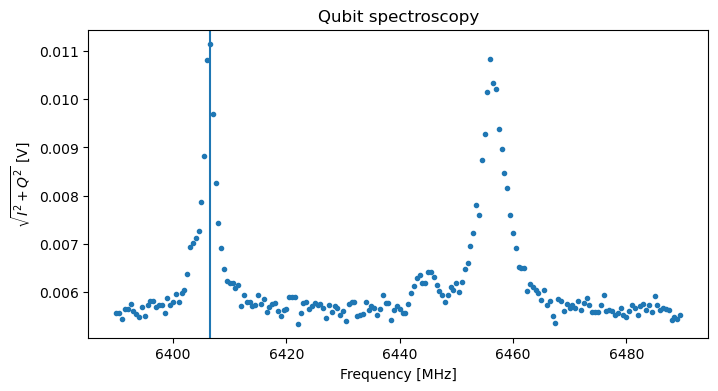

In [116]:
%matplotlib inline
# # Fetch results
# I, Q, iteration = results.fetch_all()
# # Convert I & Q to Volts
# I = u.demod2volts(I, machine.resonators[qubit_index].readout_pulse_length)
# Q = u.demod2volts(Q, machine.resonators[qubit_index].readout_pulse_length)
# sig_amp = np.sqrt(I**2 + Q**2)
# # detrend removes the linear increase of phase
# sig_phase = signal.detrend(np.unwrap(np.angle(I + 1j * Q)))
idx = np.argmax(sig_amp) # find minimum
print(f"IF offset to add to IF: {freq_sweep[idx] / u.MHz:.6f} MHz")

plt.close('all')
%matplotlib inline
# 1D spectroscopy plot
fig = plt.figure(figsize=[8, 4])
plt.title('Qubit spectroscopy')
plt.plot((machine.qubits[qubit_index].f_01 + freq_sweep) / u.MHz, sig_amp, ".")
plt.xlabel("Frequency [MHz]")
plt.ylabel(r"$\sqrt{I^2 + Q^2}$ [V]")
plt.axvline(x = (machine.qubits[qubit_index].f_01 + freq_sweep[idx]) / u.MHz)

In [30]:
savemat(os.path.join(tPath, file_name), {"ESR_freq": machine.qubits[qubit_index].f_01 + freq_sweep, "sig_amp": sig_amp, "sig_phase": sig_phase, "DC_flux": DC_ss, "ROI": ROI, "ROO": ROO, "freq_TWPA": freq_TWPA, "pwr_TWPA": pwr_TWPA})
machine._save(os.path.join(tPath, json_name), flat_data=False)

Updated f_01 (df) [MHz]: 6451894410.168393 0.3944101683931351


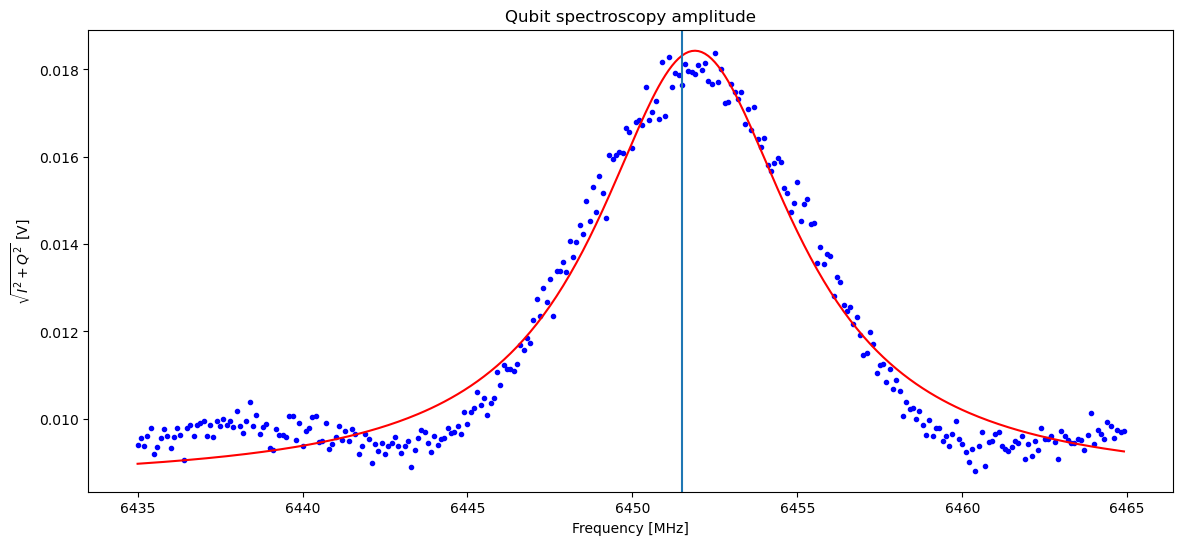

In [37]:
# fit the data
freqs = machine.qubits[qubit_index].f_01 + freq_sweep
try:
    param, dp_cov=curve_fit(ESR_Shape,freqs,sig_amp,p0=[max(sig_amp)-min(sig_amp),8E6,freqs[np.argmax(sig_amp)],min(sig_amp)] )
    d_ESR_freq = round(param[2] * 100)/100
    print('Updated f_01 (df) [MHz]:', param[2], (param[2] - machine.qubits[qubit_index].f_01) / u.MHz)
except:
    pass

# 1D spectroscopy plot
fig = plt.figure(figsize=[14, 6])
plt.plot(freqs / u.MHz, sig_amp, "b.")
plt.plot(freqs / u.MHz, ESR_Shape(freqs, param[0],param[1],param[2],param[3]), 'r')

plt.title("Qubit spectroscopy amplitude")

plt.xlabel("Frequency [MHz]")
plt.ylabel(r"$\sqrt{I^2 + Q^2}$ [V]")
plt.axvline(x=machine.qubits[qubit_index].f_01/u.MHz)
plt.show()

In [ ]:
# Fit to a double Lorentzian
freqs = machine.qubits[qubit_index].f_01 + freq_sweep
param, dp_cov=curve_fit(ESR_Shape_double,freqs,sig_amp,p0=[max(sig_amp)-min(sig_amp),8E6,freqs[np.argmax(sig_amp)],
                                                        min(sig_amp),max(sig_amp)-min(sig_amp),8E6,freqs[np.argmax(sig_amp)]] )
fig = plt.figure(figsize=[14, 6])
plt.plot(freqs / u.MHz, sig_amp, "b.")
plt.plot(freqs / u.MHz, ESR_Shape_double(freqs, param[0],param[1],param[2],param[3], param[4], param[5], param[6]), 'r')

plt.title("Qubit spectroscopy amplitude")

plt.xlabel("Frequency [MHz]")
plt.ylabel(r"$\sqrt{I^2 + Q^2}$ [V]")
print("First peak at ", param[2], "\n Second peak at ", param[6])
plt.show()

In [ ]:
freqs[np.argmax(ESR_Shape(freqs, param[0],param[1],param[2],param[3]))]

In [ ]:
machine.qubits[qubit_index].f_01 -=90.6E6
# machine.qubits[qubit_index].pi_amp = 125E-3
machine._save("quam_state.json")

## Power Rabi

In [42]:
print("Start running ...")

now = datetime.datetime.now()
month = now.strftime("%m")
day = now.strftime("%d")
hour = now.strftime("%H")
minute = now.strftime("%M")

exp_name = 'Rabi'
qubit_name = 'UA_Q2'

f_str = qubit_name + '_' + exp_name + '_' + month + day + '-' + hour + minute
file_name= f_str+'.mat'
json_name = f_str + '_state.json'

# Set-up the machine and get the config #
machine = QuAM("quam_state.json")
# machine.qubits[0].pi_amp=0.109
# machine.qubits[0].pi_length=80
config = build_config(machine)

# The QUA program #
n_avg = 10_000
cooldown_time = 20_000 # ns, set in wait() function
amps = np.arange(0.1, 1.99, 0.02)
err_amp = 1  # Number of played qubit pulses for getting a better estimate of the pi amplitude
qubit_index = 0
flux_settle_time = 250  # Flux settle time for fast flux from OP
t = 80 

with program() as power_rabi:
    n = declare(int)
    n_st = declare_stream()
    a = declare(fixed)
    I = declare(fixed)
    Q = declare(fixed)
    I_st = declare_stream()
    Q_st = declare_stream()

    with for_(n, 0, n < n_avg, n + 1):
        with for_(*from_array(a, amps)):
            # Loop for error amplification (perform many qubit pulses)
            for i in range(err_amp):
#                 play("x180" * amp(a), machine.qubits[qubit_index].name)
#                 play("pi" * amp(a), machine.qubits[qubit_index].name, duration = t * u.ns)
                play("pi" * amp(a), machine.qubits[qubit_index].name)
            align(machine.qubits[qubit_index].name, machine.resonators[qubit_index].name)
            measure(
                "readout",
                machine.resonators[qubit_index].name,
                None,
                dual_demod.full("cos", "out1", "sin", "out2", I),
                dual_demod.full("minus_sin", "out1", "cos", "out2", Q),
            )
            save(I, I_st)
            save(Q, Q_st)
            wait(cooldown_time * u.ns, machine.resonators[qubit_index].name)
        save(n, n_st)

    with stream_processing():
        I_st.buffer(len(amps)).average().save("I")
        Q_st.buffer(len(amps)).average().save("Q")
        n_st.save("iteration")

#  Open Communication with the QOP  #
# qmm = QuantumMachinesManager(machine.network.qop_ip, cluster_name=machine.network.cluster_name, octave=octave_config)
# qmm = QuantumMachinesManager(machine.network.qop_ip, port = '9510', octave=octave_config, log_level = "ERROR")
qmm = QuantumMachinesManager(machine.network.qop_ip, port = '9510', octave=octave_config)

simulate = False
if simulate:
    simulation_config = SimulationConfig(duration=1000)  # in clock cycles
    job = qmm.simulate(config, power_rabi, simulation_config)
    job.get_simulated_samples().con1.plot()
else:
    qm = qmm.open_qm(config)
    job = qm.execute(power_rabi)
    # Get results from QUA program
    results = fetching_tool(job, data_list=["I", "Q", "iteration"], mode="live")
    %matplotlib qt
    # Live plotting
    fig = plt.figure()
    plt.rcParams['figure.figsize'] = [12, 8]
    interrupt_on_close(fig, job)  # Interrupts the job when closing the figure
    while results.is_processing():
        # Fetch results
        I, Q, iteration = results.fetch_all()
        I = u.demod2volts(I, machine.resonators[qubit_index].readout_pulse_length)
        Q = u.demod2volts(Q, machine.resonators[qubit_index].readout_pulse_length)
        sig_amp = np.sqrt(I**2 + Q**2)
        sig_phase = signal.detrend(np.unwrap(np.angle(I + 1j * Q)))
        # Progress bar
        progress_counter(iteration, n_avg, start_time=results.get_start_time())
        plt.cla()
        plt.title("Power Rabi")
        plt.plot(machine.qubits[qubit_index].pi_amp*amps, sig_amp, "b.")
        plt.xlabel("Amplitude [V]")
        plt.ylabel(r"$\sqrt{I^2 + Q^2}$ [V]")
        plt.pause(0.01)
            

Start running ...
2023-10-03 13:57:36,027 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2023-10-03 13:57:36,036 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


2023-10-03 13:57:36,792 - qm - INFO     - Sending program to QOP for compilation


INFO:qm.api.frontend_api:Sending program to QOP for compilation


2023-10-03 13:57:36,989 - qm - INFO     - Executing program


INFO:qm.QuantumMachine:Executing program


Progress: [##################################################] 100.0% (n=10000/10000) --> elapsed time: 19.50s
Execution stopped by user!


In [43]:
savemat(os.path.join(tPath, file_name), {"Rabi_amp": machine.qubits[qubit_index].pi_amp * amps, "sig": sig_amp, "sig_phase": sig_phase, "DC_flux": DC_ss, "ROI": ROI, "ROO": ROO, "freq_TWPA": freq_TWPA, "pwr_TWPA": pwr_TWPA})
machine._save(os.path.join(tPath, json_name), flat_data=False)

In [44]:
# fit the data
try:
    param, dp_cov=curve_fit(Rabi_Shape,amps,sig_amp,p0=[(max(sig_amp)-min(sig_amp))/2,0.5,0,(max(sig_amp)+min(sig_amp))/2] )
    amp_pi = round(((0.5-param[2]/2/np.pi)/param[1]) * 10000)/10000
    print('Updated amp_pi [V]:', amp_pi)
except:
    pass

# 1D spectroscopy plot
fig = plt.figure(figsize=[14, 6])
plt.plot(amps, sig_amp, "b.")
plt.plot(amps, Rabi_Shape(amps, param[0],param[1],param[2],param[3]), 'r')
plt.show()
plt.title("Rabi pulse amplitude [V]")

plt.xlabel("Amplitude [a.u.]")
plt.ylabel(r"$\sqrt{I^2 + Q^2}$ [V]")
# plt.axvline(x=amp_pi)
print(amps[np.argmax(Rabi_Shape(amps, param[0],param[1],param[2],param[3]))])

Updated amp_pi [V]: 1.0157
1.0200000000000002


In [45]:
machine.qubits[qubit_index].pi_amp =  0.020557672687122486*1.02
# machine.qubits[qubit_index].pi_length = 180
# machine.flux_lines[qubit_index].flux_pulse_length = 152
# machine.flux_lines[qubit_index].flux_pulse_amp = 0.25

machine._save("quam_state.json", flat_data=False)

## Time Rabi

In [87]:
print("Start running ...")

now = datetime.datetime.now()
month = now.strftime("%m")
day = now.strftime("%d")
hour = now.strftime("%H")
minute = now.strftime("%M")

exp_name = 'Rabi_time'
qubit_name = 'UA_Q2'

f_str = qubit_name + '_' + exp_name + '_' + month + day + '-' + hour + minute
file_name= f_str+'.mat'
json_name = f_str + '_state.json'

# Set-up the machine and get the config #
machine = QuAM("quam_state.json")
# machine.qubits[0].pi_amp=0.109
# machine.qubits[0].pi_length=80
config = build_config(machine)

# The QUA program #
n_avg = 10_000
cooldown_time = 20_000 # ns, set in wait() function

taus = np.arange(1, 300 + 0.1, 1)  # in units of clock cyles
taus = taus.astype(int)
qubit_index = 0

with program() as time_rabi:
    n = declare(int)
    n_st = declare_stream()
    t = declare(int)
    I = declare(fixed)
    Q = declare(fixed)
    I_st = declare_stream()
    Q_st = declare_stream()
    

    with for_(n, 0, n < n_avg, n + 1):
        with for_(*from_array(t, taus)):
            play("pi" * amp(0.5), machine.qubits[qubit_index].name, duration = t)
#             play("x180" * amp(0.73), machine.qubits[qubit_index].name, duration = t)
            align(machine.qubits[qubit_index].name, machine.resonators[qubit_index].name)
            measure(
                "readout",
                machine.resonators[qubit_index].name,
                None,
                dual_demod.full("cos", "out1", "sin", "out2", I),
                dual_demod.full("minus_sin", "out1", "cos", "out2", Q),
            )
            save(I, I_st)
            save(Q, Q_st)
            wait(cooldown_time * u.ns, machine.resonators[qubit_index].name)
        save(n, n_st)

    with stream_processing():
        I_st.buffer(len(taus)).average().save("I")
        Q_st.buffer(len(taus)).average().save("Q")
        n_st.save("iteration")

#  Open Communication with the QOP  #
# qmm = QuantumMachinesManager(machine.network.qop_ip, cluster_name=machine.network.cluster_name, octave=octave_config)
# qmm = QuantumMachinesManager(machine.network.qop_ip, port = '9510', octave=octave_config, log_level = "ERROR")
qmm = QuantumMachinesManager(machine.network.qop_ip, port = '9510', octave=octave_config)

simulate = False
if simulate:
    simulation_config = SimulationConfig(duration=1000)  # in clock cycles
    job = qmm.simulate(config, time_rabi, simulation_config)
    job.get_simulated_samples().con1.plot()
else:
    qm = qmm.open_qm(config)
    job = qm.execute(time_rabi)
    # Get results from QUA program
    results = fetching_tool(job, data_list=["I", "Q", "iteration"], mode="live")
    %matplotlib qt
    # Live plotting
    fig = plt.figure()
    plt.rcParams['figure.figsize'] = [12, 8]
    interrupt_on_close(fig, job)  # Interrupts the job when closing the figure
    while results.is_processing():
        # Fetch results
        I, Q, iteration = results.fetch_all()
        I = u.demod2volts(I, machine.resonators[qubit_index].readout_pulse_length)
        Q = u.demod2volts(Q, machine.resonators[qubit_index].readout_pulse_length)
        sig_amp = np.sqrt(I**2 + Q**2)
        sig_phase = signal.detrend(np.unwrap(np.angle(I + 1j * Q)))
        # Progress bar
        progress_counter(iteration, n_avg, start_time=results.get_start_time())
        plt.cla()
        plt.title("Time Rabi")
        plt.plot(taus *4, sig_amp, "b.")
        plt.xlabel("Tau [ns]")
        plt.ylabel(r"$\sqrt{I^2 + Q^2}$ [V]")
        plt.pause(0.01)

Start running ...
2023-10-03 16:35:56,827 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2023-10-03 16:35:56,836 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


2023-10-03 16:35:57,573 - qm - INFO     - Sending program to QOP for compilation


INFO:qm.api.frontend_api:Sending program to QOP for compilation


2023-10-03 16:35:57,759 - qm - INFO     - Executing program


INFO:qm.QuantumMachine:Executing program


Execution stopped by user!##################                 ] 67.1% (n=6714/10000) --> elapsed time: 42.38s


In [86]:
 I, Q, iteration = results.fetch_all()
I = u.demod2volts(I, machine.resonators[qubit_index].readout_pulse_length)
Q = u.demod2volts(Q, machine.resonators[qubit_index].readout_pulse_length)
sig_amp = np.sqrt(I**2 + Q**2)
sig_phase = signal.detrend(np.unwrap(np.angle(I + 1j * Q)))
# Progress bar
progress_counter(iteration, n_avg, start_time=results.get_start_time())
plt.cla()
plt.title("Time Rabi")
plt.plot(taus *4, sig_amp, "b.")
plt.xlabel("Tau [ns]")
plt.ylabel(r"$\sqrt{I^2 + Q^2}$ [V]")
plt.pause(0.01)

Progress: [##################################################] 100.0% (n=10000/10000) --> elapsed time: 94.04s


In [40]:
# machine.qubits[qubit_index].pi_amp = 0.1092*0.5
machine.qubits[qubit_index].pi_length = 116
machine._save("quam_state.json")

In [41]:
savemat(os.path.join(tPath, file_name), {"Rabi_time": taus*4, "sig": sig_amp, "sig_phase": sig_phase, "DC_flux": DC_ss, "ROI": ROI, "ROO": ROO, "freq_TWPA": freq_TWPA, "pwr_TWPA": pwr_TWPA})
machine._save(os.path.join(tPath, json_name), flat_data=False)

## T1

In [46]:
print("Start running ...")

now = datetime.datetime.now()
month = now.strftime("%m")
day = now.strftime("%d")
hour = now.strftime("%H")
minute = now.strftime("%M")

exp_name = 'T1'
qubit_name = 'UA_Q2'

f_str = qubit_name + '_' + exp_name + '_' + month + day + '-' + hour + minute
file_name= f_str+'.mat'
json_name = f_str + '_state.json'

machine = QuAM("quam_state.json")
config = build_config(machine)

# The QUA program #
tau_min = 100 # clock cycle
tau_max = 3_000 # clock cycle
d_tau = 50 # clock cycle
tau_sweep = np.arange(tau_min, tau_max + 0.1, d_tau)  # + 0.1 to add t_max to taus
tau_sweep = tau_sweep.astype(int)
qubit_index = 0

n_avg = 10000
cooldown_time = 20_000 # ns

with program() as T1:
    n = declare(int)
    n_st = declare_stream()
    I = declare(fixed)
    I_st = declare_stream()
    Q = declare(fixed)
    Q_st = declare_stream()
    tau = declare(int)

    with for_(n, 0, n < n_avg, n + 1):
        with for_(*from_array(tau, tau_sweep)):
            play("pi", machine.qubits[qubit_index].name)
            wait(tau, machine.qubits[qubit_index].name)
            align(machine.qubits[qubit_index].name, machine.resonators[qubit_index].name)
            measure(
                "readout",
                machine.resonators[qubit_index].name,
                None,
                dual_demod.full("rotated_cos", "out1", "rotated_sin", "out2", I),
                dual_demod.full("rotated_minus_sin", "out1", "rotated_cos", "out2", Q),
            )
            save(I, I_st)
            save(Q, Q_st)
            wait(cooldown_time * u.ns, machine.resonators[qubit_index].name)
        save(n, n_st)

    with stream_processing():
        I_st.buffer(len(tau_sweep)).average().save("I")
        Q_st.buffer(len(tau_sweep)).average().save("Q")
        n_st.save("iteration")

#  Open Communication with the QOP  #
# qmm = QuantumMachinesManager(machine.network.qop_ip, cluster_name=machine.network.cluster_name, octave=octave_config)
# qmm = QuantumMachinesManager(machine.network.qop_ip, port = '9510', octave=octave_config, log_level = "ERROR")
qmm = QuantumMachinesManager(machine.network.qop_ip, port = '9510', octave=octave_config)

# Simulate or execute #
simulate = False
if simulate:
    simulation_config = SimulationConfig(duration=20_000)  # in clock cycles
    job = qmm.simulate(config, T1, simulation_config)
    job.get_simulated_samples().con1.plot()

else:
    print(datetime.datetime.now(),2)
    qm = qmm.open_qm(config)
    job = qm.execute(T1)
    
    # Get results from QUA program
    results = fetching_tool(job, data_list=["I", "Q", "iteration"], mode="live")
    %matplotlib qt
    # Live plotting
    fig = plt.figure()
    plt.rcParams['figure.figsize'] = [12, 8]
    interrupt_on_close(fig, job)  # Interrupts the job when closing the figure    while results.is_processing():
    while results.is_processing():
        # Fetch results
        I, Q, iteration = results.fetch_all()
        I = u.demod2volts(I, machine.resonators[qubit_index].readout_pulse_length)
        Q = u.demod2volts(Q, machine.resonators[qubit_index].readout_pulse_length)
        sig_amp = np.sqrt(I**2 + Q**2)
        sig_phase = signal.detrend(np.unwrap(np.angle(I + 1j * Q)))
        # Progress bar
        progress_counter(iteration, n_avg, start_time=results.get_start_time())
        plt.cla()
        plt.title("T1")
        plt.plot(tau_sweep *4, sig_amp, "b.")
        plt.xlabel("Tau [ns]")
        plt.ylabel(r"$\sqrt{I^2 + Q^2}$ [V]")
        plt.pause(0.01)

Start running ...
2023-10-03 13:59:17,732 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2023-10-03 13:59:17,744 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


2023-10-03 13:59:17.747154 2
2023-10-03 13:59:18,499 - qm - INFO     - Sending program to QOP for compilation


INFO:qm.api.frontend_api:Sending program to QOP for compilation


2023-10-03 13:59:18,681 - qm - INFO     - Executing program


INFO:qm.QuantumMachine:Executing program


Progress: [##################################################] 100.0% (n=10000/10000) --> elapsed time: 15.79s


In [47]:
savemat(os.path.join(tPath, file_name), {"tau": tau_sweep *4, "sig_amp": sig_amp, "sig_phase": sig_phase, "DC_flux": DC_ss, "ROI": ROI, "ROO": ROO, "freq_TWPA": freq_TWPA, "pwr_TWPA": pwr_TWPA})
machine._save(os.path.join(tPath, json_name), flat_data=False)

In [48]:
try:
    param, _ = curve_fit(exp_decay,tau_sweep *4,sig_amp,p0=[max(sig_amp)-min(sig_amp),4E3,min(sig_amp)] )
    q_T1 = round(param[1])
    print('Qubit T1 [us]:', q_T1 /u.us)
except:
    pass

# 1D spectroscopy plot
fig = plt.figure(figsize=[14, 6])
plt.plot(tau_sweep *4 /u.us, sig_amp, "b.")
plt.plot(tau_sweep *4 / u.us, exp_decay(tau_sweep *4, param[0],param[1],param[2]), 'r')
plt.show()
plt.title("Qubit T1")
plt.xlabel("tau [us]")
plt.ylabel("$\sqrt{I^2 + Q^2}$ [V]")

Qubit T1 [us]: 3.828


Text(0, 0.5, '$\\sqrt{I^2 + Q^2}$ [V]')

In [49]:
machine.qubits[qubit_index].T1 = q_T1
machine._save("quam_state.json", flat_data=False)

## Qubit tuning curve unoptimized

In [ ]:
%matplotlib qt

In [78]:
# qubit tuning curve with no optimization (full frequency spectrum)

print("Start running ...")

now = datetime.datetime.now()
month = now.strftime("%m")
day = now.strftime("%d")
hour = now.strftime("%H")
minute = now.strftime("%M")

exp_name = 'qubit_spec_flux_unopt'
qubit_name = 'UA_Q2'

f_str = qubit_name + '_' + exp_name + '_' + month + day + '-' + hour + minute
file_name= f_str+'.mat'
json_name = f_str + '_state.json'


# Set-up the machine and get the config #
machine = QuAM("quam_state.json")
config = build_config(machine)

# Program-specific variables #
n_avg =5_000  # Number of averaging loops
cooldown_time = 20_000  # Resonator cooldown time, convert to ns in the wait() function 

ff_sweep = np.arange(-0.5,0.5+0.1,0.02)
q_freq_sweep = np.arange(-100e6, 100e6, 1e6)
q_freq_sweep = q_freq_sweep.astype(int)
flux_settle_time = 100
z_duration = machine.qubits[qubit_index].pi_length + 40
qb_if = machine.qubits[qubit_index].f_01 - machine.qubits[qubit_index].lo
start_time = time.time()

with program() as qubit_spec_2D_unopt:
    n = declare(int)  # Averaging index
    damp = declare(fixed)  # ff sweep index
    df = declare(int)  # Resonator frequency
    I = declare(fixed)
    Q = declare(fixed)
    I_st = declare_stream()
    Q_st = declare_stream()
    n_st = declare_stream()
    
    with for_(n, 0, n < n_avg, n + 1):
        with for_(*from_array(damp, ff_sweep)):
            with for_(*from_array(df, q_freq_sweep)):
                update_frequency(machine.qubits[qubit_index].name, qb_if + df)
                align()
                play("const" * amp(damp), machine.flux_lines[qubit_index].name, duration = z_duration * u.ns)
                wait(5, machine.qubits[qubit_index].name)
                play('pi',machine.qubits[qubit_index].name)
                align(machine.qubits[qubit_index].name, machine.flux_lines[qubit_index].name,machine.resonators[qubit_index].name)
                # Measure the resonator
                measure(
                    "readout",
                    machine.resonators[qubit_index].name,
                    None,
                    dual_demod.full("cos", "out1", "sin", "out2", I),
                    dual_demod.full("minus_sin", "out1", "cos", "out2", Q),
                )
                align()
#                 play("const" * amp((-1)*damp), machine.flux_lines[qubit_index].name, duration = z_duration * u.ns)
                # Wait for the resonator to cooldown
                wait(cooldown_time * u.ns, machine.resonators[qubit_index].name)
                # Save data to the stream processing
                save(I, I_st)
                save(Q, Q_st)
        save(n, n_st)

    with stream_processing():
        I_st.buffer(len(q_freq_sweep)).buffer(len(ff_sweep)).average().save("I")
        Q_st.buffer(len(q_freq_sweep)).buffer(len(ff_sweep)).average().save("Q")
        n_st.save("iteration")

    # to save all the frequencies used in the scan
    q_freq_sweep_2D, ff_amp_sweep_2D = np.meshgrid(q_freq_sweep+ machine.qubits[qubit_index].f_01, ff_sweep * machine.flux_lines[qubit_index].flux_pulse_amp)

qmm = QuantumMachinesManager(machine.network.qop_ip, port = '9510', octave=octave_config)

simulate = False
if simulate:
    simulation_config = SimulationConfig(
        duration=8000, simulation_interface=LoopbackInterface([("con1", 3, "con1", 1)])
    )
    job = qmm.simulate(config, qubit_spec_2D_unopt, simulation_config)
    job.get_simulated_samples().con1.plot()
else:
    qm = qmm.open_qm(config)
    job = qm.execute(qubit_spec_2D_unopt)
    # Creates results handles to fetch the data
    results = fetching_tool(job, data_list=["I", "Q", "iteration"], mode="live")
    # Live plotting
    fig = plt.figure()
    interrupt_on_close(fig, job)  #  Interrupts the job when closing the figure
    while results.is_processing():
        # Fetch results
        I, Q, iteration = results.fetch_all()
        progress_counter(iteration, n_avg, start_time=results.get_start_time())
        # Convert results into Volts
        sigs = u.demod2volts(I + 1j * Q, machine.resonators[qubit_index].readout_pulse_length)
        sig_amp = np.abs(sigs)  # Amplitude
        sig_phase = np.angle(sigs)  # Phase
        # Plot results
        progress_counter(iteration, n_avg, start_time=results.get_start_time())
        plt.cla()
        plt.title("Qubit spectroscopy amplitude")
        plt.pcolormesh(ff_amp_sweep_2D, q_freq_sweep_2D.astype(float), sig_amp ,cmap="seismic")
        plt.ylabel("Qubit frequency [MHz]")
        plt.xlabel("Flux level [V]")
        plt.pause(0.1)
        plt.tight_layout() 
print("Finished!")    
  


   

Start running ...
2023-10-03 16:25:08,192 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2023-10-03 16:25:08,202 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


2023-10-03 16:25:09,120 - qm - INFO     - Sending program to QOP for compilation


INFO:qm.api.frontend_api:Sending program to QOP for compilation


2023-10-03 16:25:09,342 - qm - INFO     - Executing program


INFO:qm.QuantumMachine:Executing program


Execution stopped by user!                                   ] 14.0% (n=700/5000) --> elapsed time: 160.74s
Finished! [#######                                           ] 14.0% (n=701/5000) --> elapsed time: 161.25s


In [ ]:
# plot and fit
plt.figure()
plt.ylabel("Qubit frequency [MHz]")
plt.xlabel("Flux level [V]")
plt.pcolormesh(ff_amp_sweep_2D, q_freq_sweep_2D.astype(float)/u.MHz, sig_amp ,cmap="seismic")
plt.colorbar()

# Determine minima of signal to use as ydata for fitting
maximas = []
flux = ff_sweep * machine.flux_lines[qubit_index].flux_pulse_amp

# Remove edges on flux to avoid having data from top curve
bound = 0.045
flux_int = np.array([i for i in flux if ((i>= -bound) & (i<= bound))])
flux_int_idx = np.array([i for i,v in enumerate((flux>= -bound) & (flux<= bound))  if v])

for i in (flux_int_idx):
    maximas.append(q_freq_sweep_2D[i][np.argmax(sig_amp[i])])

## Plot minima of signal
maximas= np.array(maximas)
plt.scatter(flux_int.T, maximas/1e6)

initial_guess = [1, 0, 6260]  # Initial guess for the parameters
fit_params, _ = curve_fit(poly2, flux_int, maximas/1e6, p0=initial_guess)

fitted_curve = poly2(flux_int, *fit_params)
# Plot fitted data
plt.plot(flux_int, fitted_curve, label='Fitted Cosine', color='orange')
fitted_curve = fitted_curve*u.kHz
fitted_curve = fitted_curve.astype(int)

# Sweet spot from fit
SS_cal = -fit_params[1]/(2*fit_params[0])
print(SS_cal)

In [ ]:
savemat(os.path.join(tPath, file_name), {"q_freq": q_freq_sweep_2D, "sig_amp": sig_amp, "sig_phase": sig_phase, "fast_flux_sweep": ff_amp_sweep_2D, "ROI": ROI, "ROO": ROO, "freq_TWPA": freq_TWPA, "pwr_TWPA": pwr_TWPA})
machine._save(os.path.join(tPath, json_name), flat_data=False)

## Tuning curve using Hamiltonian 

In [ ]:
## Working tuning curve using freq from Hamiltonian

print("Start running ...")

now = datetime.datetime.now()
month = now.strftime("%m")
day = now.strftime("%d")
hour = now.strftime("%H")
minute = now.strftime("%M")

exp_name = 'qubit_spec_flux_sweep_ham'
qubit_name = 'UA_Q2'

f_str = qubit_name + '_' + exp_name + '_' + month + day + '-' + hour + minute
file_name= f_str+'.mat'
json_name = f_str + '_state.json'

# Set-up the machine and get the config #
machine = QuAM("quam_state.json")
config = build_config(machine)

# Program-specific variables #
n_avg = 1_000  # Number of averaging loops
qubit_index = 0 
cooldown_time = 10_000  # Resonator cooldown time, convert to ns in the wait() function 

ff_amp_sweep = np.arange(-0.75,0.75+1E-5,0.02)
freq_est_diff = (machine.qubits[qubit_index].f_01-1E6*ham([SS], 2, *popt))[0] / 1e3 # in kHz
q_freq_est = ham(machine.flux_lines[qubit_index].flux_pulse_amp * ff_amp_sweep+SS, 2, *popt) * 1e3 + freq_est_diff # in kHz
q_freq_est = q_freq_est.astype(int) # in kHz

q_freq_sweep = np.arange(-100, 100, 1) # this gets multiplied by 1e6 inside the loop
z_duration = machine.qubits[qubit_index].pi_length + 40
lo = machine.qubits[qubit_index].lo/1e3

with program() as qubit_spec_2D_ham:
    n = declare(int)  # Averaging index
    df = declare(int)  # Qubit sweep
    q_freq_est_i = declare(int)  # Estimated qubit frequency
    damp = declare(fixed)  # Z amplitude sweep
    I = declare(fixed)
    Q = declare(fixed)
    I_st = declare_stream()
    Q_st = declare_stream()
    n_st = declare_stream()
    qb_if = declare(int)
    
    with for_(n, 0, n < n_avg, n + 1):
        with for_each_((damp,q_freq_est_i),(ff_amp_sweep,q_freq_est)):
            assign(qb_if, (q_freq_est_i - lo)*1e3)

            with for_(*from_array(df,q_freq_sweep)):
                update_frequency(machine.qubits[qubit_index].name, qb_if + df * u.MHz)
                play("const" * amp(damp), machine.flux_lines[qubit_index].name, duration = z_duration * u.ns)
                wait(5, machine.qubits[qubit_index].name)
                play('pi',machine.qubits[qubit_index].name)
                align(machine.qubits[qubit_index].name, machine.flux_lines[qubit_index].name,machine.resonators[qubit_index].name)
                # Measure the resonator
                measure(
                    "readout",
                    machine.resonators[qubit_index].name,
                    None,
                    dual_demod.full("cos", "out1", "sin", "out2", I),
                    dual_demod.full("minus_sin", "out1", "cos", "out2", Q),
                )
                align()
                play("const" * amp((-1)*damp), machine.flux_lines[qubit_index].name, duration = z_duration * u.ns)
                # Wait for the resonator to cooldown
                wait(cooldown_time * u.ns, machine.resonators[qubit_index].name)
                # Save data to the stream processing
                save(I, I_st)
                save(Q, Q_st)
        save(n, n_st)

    with stream_processing():
        I_st.buffer(len(q_freq_sweep)).buffer(len(ff_amp_sweep)).average().save("I")
        Q_st.buffer(len(q_freq_sweep)).buffer(len(ff_amp_sweep)).average().save("Q")
        n_st.save("iteration")

    # to save all the frequencies used in the scan
    q_freq_sweep_2D, q_freq_est_2D = np.meshgrid(q_freq_sweep*1e6, q_freq_est.astype(float) * 1e3)
    _, ff_amp_sweep_2D = np.meshgrid(q_freq_sweep*1e6, ff_amp_sweep * machine.flux_lines[qubit_index].flux_pulse_amp)
    q_freq_sweep_2D = q_freq_est_2D + q_freq_sweep_2D

qmm = QuantumMachinesManager(machine.network.qop_ip, port = '9510', octave=octave_config)

simulate = False
if simulate:
    %matplotlib qt
    job = qmm.simulate(config, qubit_spec_2D_ham, SimulationConfig(4000))
    job.get_simulated_samples().con1.plot()
else:
    qm = qmm.open_qm(config)
    job = qm.execute(qubit_spec_2D_ham)
    # Creates results handles to fetch the data
    results = fetching_tool(job, data_list=["I", "Q", "iteration"], mode="live")
    # Live plotting
    fig = plt.figure()
    interrupt_on_close(fig, job)  #  Interrupts the job when closing the figure
    while results.is_processing():
        # Fetch results
        I, Q, iteration = results.fetch_all()
        progress_counter(iteration, n_avg, start_time=results.get_start_time())
        # Convert results into Volts
        sigs = u.demod2volts(I + 1j * Q, machine.resonators[qubit_index].readout_pulse_length)
        sig_amp = np.abs(sigs)  # Amplitude
        sig_phase = np.angle(sigs)  # Phase
        # Plot results
        progress_counter(iteration, n_avg, start_time=results.get_start_time())
        plt.cla()
        plt.title("Qubit spectroscopy amplitude")
        plt.pcolormesh(ff_amp_sweep_2D, q_freq_sweep_2D.astype(float), sig_amp ,cmap="seismic")
        plt.ylabel("Qubit frequency [MHz]")
        plt.xlabel("Flux level [V]")
        plt.pause(0.1)
        plt.tight_layout() 
print("Finished!")




In [ ]:
# plot and fit
plt.figure()
plt.ylabel("Qubit frequency [MHz]")
plt.xlabel("Flux level [V]")
plt.pcolormesh(ff_amp_sweep_2D, q_freq_sweep_2D.astype(float)/u.MHz, sig_amp ,cmap="seismic")
plt.colorbar()

# Determine minima of signal to use as ydata for fitting
maximas = []
flux = ff_amp_sweep * machine.flux_lines[qubit_index].flux_pulse_amp

# Remove edges on flux to avoid having data from top curve
bound = 0.05
flux_int = np.array([i for i in flux if ((i>= -bound) & (i<= bound))])
flux_int_idx = np.array([i for i,v in enumerate((flux>= -bound) & (flux<= bound))  if v])

for i in (flux_int_idx):
    maximas.append(q_freq_sweep_2D[i][np.argmax(sig_amp[i])])

## Plot minima of signal
maximas= np.array(maximas)
plt.scatter(flux_int.T, maximas/1e6)

initial_guess = [1, 0, 6250]  # Initial guess for the parameters
fit_params, _ = curve_fit(poly2, flux_int, maximas/1e6, p0=initial_guess)

fitted_curve = poly2(flux_int, *fit_params)
# Plot fitted data
plt.plot(flux_int, fitted_curve, label='Fitted Cosine', color='orange')
fitted_curve = fitted_curve*u.kHz
fitted_curve = fitted_curve.astype(int)

# Sweet spot from fit
SS_cal = -fit_params[1]/(2*fit_params[0])
print(SS_cal)

In [ ]:
# Save data 
savemat(os.path.join(tPath, file_name), {"qubit_freq": q_freq_sweep_2D, "sig_amp": sig_amp, "sig_phase": sig_phase, "ff_sweep": ff_amp_sweep_2D, "ROI": ROI, "ROO": ROO, "freq_TWPA": freq_TWPA, "pwr_TWPA": pwr_TWPA})
machine._save(os.path.join(tPath, json_name), flat_data=False)

In [ ]:
# load data from file
file_name = 'UA_Q2_qubit_spec_flux_sweep_0907-1453'
data = loadmat(os.path.join(r"Z:\LabberData_DF5\QM_Data_DF5\2023\09\Data_0907", file_name))
freq = data['qubit_freq']
sig_amp = data['sig_amp']
ff_sweep = data['ff_sweep']

plt.figure()
plt.ylabel("Qubit frequency [MHz]")
plt.xlabel("Flux level [V]")
plt.pcolormesh(ff_sweep, freq.astype(float)/1e6, sig_amp ,cmap="seismic")
plt.colorbar()

# Determine minima of signal to use as ydata for fitting
maximas = []
flux = ff_sweep

# Remove edges on flux to avoid having data from top curve
flux_int = np.array([i for i in flux if np.any((i>= -0.08) & (i<= 0.08))])
flux_int_idx = np.array([i for i,v in enumerate((flux>= -0.08) & (flux<= 0.08))  if np.any(v)])

for i in (flux_int_idx):
    maximas.append(freq[i][np.argmax(sig_amp[i])])

## Plot minima of signal
maximas = np.array(maximas)
plt.scatter(flux_int.T[0], maximas/1e6)

initial_guess = [1, 0, 6405]  # Initial guess for the parameters
fit_params, _ = curve_fit(poly2, flux_int.T[0], maximas/1e6, p0=initial_guess)

fitted_curve = poly2(flux_int.T[0], *fit_params)
# Plot fitted data
plt.plot(flux_int.T[0], fitted_curve, label='Fitted Cosine', color='orange')
fitted_curve = fitted_curve*u.kHz
fitted_curve = fitted_curve.astype(int)

# Sweet spot from fit
SS_cal = -fit_params[1]/(2*fit_params[0])
print(SS_cal)

## Tuning curve using fit to second order poly

In [ ]:
# Takes the frequency from the fitted data to the second order poly

print("Start running ...")

now = datetime.datetime.now()
month = now.strftime("%m")
day = now.strftime("%d")
hour = now.strftime("%H")
minute = now.strftime("%M")

exp_name = 'qubit_spec_flux_sweep_2poly'
qubit_name = 'UA_Q2'

f_str = qubit_name + '_' + exp_name + '_' + month + day + '-' + hour + minute
file_name= f_str+'.mat'
json_name = f_str + '_state.json'

# Set-up the machine and get the config #
machine = QuAM("quam_state.json")
config = build_config(machine)

# Program-specific variables #
n_avg = 1_000  # Number of averaging loops
qubit_index = 0 
cooldown_time = 10_000  # Resonator cooldown time, convert to ns in the wait() function 

ff_amp_sweep = np.arange(-0.5,0.5+1E-5,0.01)
qubit_freq_fit = poly2(ff_amp_sweep* machine.flux_lines[qubit_index].flux_pulse_amp, *fit_params)
qubit_freq_fit = qubit_freq_fit*u.kHz
q_freq_est = qubit_freq_fit.astype(int)
lo = machine.qubits[qubit_index].lo/1e3
q_freq_sweep = np.arange(-50, 50, 1)
z_duration = machine.qubits[qubit_index].pi_length + 40

with program() as qubit_spec_2D_2poly:
    n = declare(int)  # Averaging index
    df = declare(int)  # Qubit sweep
    q_freq_est_i = declare(int)  # Estimated qubit frequency
    damp = declare(fixed)  # Z amplitude sweep
    I = declare(fixed)
    Q = declare(fixed)
    I_st = declare_stream()
    Q_st = declare_stream()
    n_st = declare_stream()
    qb_if = declare(int)
    
    with for_(n, 0, n < n_avg, n + 1):
        with for_each_((damp,q_freq_est_i),(ff_amp_sweep,q_freq_est)):
            assign(qb_if, (q_freq_est_i - lo)*1e3)
            with for_(*from_array(df,q_freq_sweep)):
                update_frequency(machine.qubits[qubit_index].name, qb_if + df*1e6)
                play("const" * amp(damp), machine.flux_lines[qubit_index].name, duration = z_duration * u.ns)
                wait(5, machine.qubits[qubit_index].name)
                play('pi',machine.qubits[qubit_index].name)
                align(machine.qubits[qubit_index].name, machine.flux_lines[qubit_index].name,machine.resonators[qubit_index].name)
                # Measure the resonator
                measure(
                    "readout",
                    machine.resonators[qubit_index].name,
                    None,
                    dual_demod.full("cos", "out1", "sin", "out2", I),
                    dual_demod.full("minus_sin", "out1", "cos", "out2", Q),
                )
                align()
                play("const" * amp((-1)*damp), machine.flux_lines[qubit_index].name, duration = z_duration * u.ns)
                # Wait for the resonator to cooldown
                wait(cooldown_time * u.ns, machine.resonators[qubit_index].name)
                # Save data to the stream processing
                save(I, I_st)
                save(Q, Q_st)
        save(n, n_st)

    with stream_processing():
        I_st.buffer(len(q_freq_sweep)).buffer(len(ff_amp_sweep)).average().save("I")
        Q_st.buffer(len(q_freq_sweep)).buffer(len(ff_amp_sweep)).average().save("Q")
        n_st.save("iteration")

    # to save all the frequencies used in the scan
    q_freq_sweep_2D, q_freq_est_2D = np.meshgrid(q_freq_sweep *1e6, q_freq_est.astype(float) * 1e3)
    _, ff_amp_sweep_2D = np.meshgrid(q_freq_sweep*1e6, ff_amp_sweep * machine.flux_lines[qubit_index].flux_pulse_amp)
    q_freq_sweep_2D = q_freq_est_2D + q_freq_sweep_2D

###############
# Run Program #
###############
#  Open Communication with the QOP  #
# qmm = QuantumMachinesManager(machine.network.qop_ip, cluster_name=machine.network.cluster_name, octave=octave_config)
# qmm = QuantumMachinesManager(machine.network.qop_ip, port = '9510', octave=octave_config, log_level = "ERROR")
qmm = QuantumMachinesManager(machine.network.qop_ip, port = '9510', octave=octave_config)

simulate = False
if simulate:
    %matplotlib qt
    job = qmm.simulate(config, qubit_spec_2D_2poly, SimulationConfig(4000))
    job.get_simulated_samples().con1.plot()
else:
    qm = qmm.open_qm(config)
    job = qm.execute(qubit_spec_2D_2poly)
    # Creates results handles to fetch the data
    results = fetching_tool(job, data_list=["I", "Q", "iteration"], mode="live")
    # Live plotting
    fig = plt.figure()
    interrupt_on_close(fig, job)  #  Interrupts the job when closing the figure
    while results.is_processing():
        # Fetch results
        I, Q, iteration = results.fetch_all()
        progress_counter(iteration, n_avg, start_time=results.get_start_time())
        # Convert results into Volts
        sigs = u.demod2volts(I + 1j * Q, machine.resonators[qubit_index].readout_pulse_length)
        sig_amp = np.abs(sigs)  # Amplitude
        sig_phase = np.angle(sigs)  # Phase
        # Plot results
        plt.cla()
        plt.title("Qubit spectroscopy amplitude")
        plt.pcolormesh(ff_amp_sweep_2D, q_freq_sweep_2D.astype(float), sig_amp ,cmap="seismic")
        
#         plt.pcolormesh(ff_amp_sweep, q_freq_sweep.astype(float) * u.kHz, sig_amp, shading='auto',cmap="seismic")
        plt.ylabel("Qubit frequency [MHz]")
        plt.xlabel("Flux level [V]")
        plt.pause(0.1)
        plt.tight_layout() 
plt.colorbar()
print("Finished!")    
  
    
# # this is to generate qua script for QM people to troubleshoot
# sourceFile = open('debug.py', 'w')
# print(generate_qua_script(qubit_spec_2D, config), file=sourceFile)
# sourceFile.close()

    
 

In [ ]:
# Save data 
savemat(os.path.join(tPath, file_name), {"qubit_freq": q_freq_sweep_2D, "sig_amp": sig_amp, "sig_phase": sig_phase, "ff_sweep": ff_amp_sweep_2D, "ROI": ROI, "ROO": ROO, "freq_TWPA": freq_TWPA, "pwr_TWPA": pwr_TWPA})
machine._save(os.path.join(tPath, json_name), flat_data=False)